# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [3]:
from google.colab import drive

# Check if drive is already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive', force_remount=True)
else:
  print("Drive already mounted.")
%cd /content/drive/My Drive/[2024-2025] AN2DL/Homework 1

Drive already mounted.
/content/drive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [4]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
np.random.seed(42)
tf.random.set_seed(42);
import pandas as pd
#da togliere dopo
import random
import matplotlib.pyplot as plt
seed = 42

## ⏳ Load the Data

In [5]:
import numpy as np

data = np.load('training_set.npz')
x = data['images']
y = data['labels']   # etichette

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

# Normalize data to the range [0, 1]
x = (x / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y= tfk.utils.to_categorical(y)

x_train, x_val, y_train, y_val= train_test_split(x, y, test_size=0.1, random_state=seed, stratify=y)
# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())
# Print the shapes of the loaded datasets
print("Training Data Shape:", x_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", x_val.shape)
print("Validation Label Shape:", y_val.shape)



Counting occurrences of target classes:
digit
6    2530
1    2381
3    2226
7    1843
5    1393
2    1285
0    1052
4    1049
Name: count, dtype: int64
Training Data Shape: (12383, 96, 96, 3)
Training Label Shape: (12383, 8)
Validation Data Shape: (1376, 96, 96, 3)
Validation Label Shape: (1376, 8)


In [6]:
# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 1. 0. 0.]
"Default" label: 5


## 🛠️ Train and Save the Model

In [45]:
# Input shape for the model
input_shape = x_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# Number of training epochs
epochs = 50

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)



Input Shape: (96, 96, 3)
Output Shape: 8
Epochs: 50
Batch Size: 64
Learning Rare: 0.001


In [46]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Salviamo la connessione shortcut
    shortcut = x

    # Prima convoluzione 1x1 (riduzione dei filtri)
    x = tfkl.Conv2D(filters // 4, kernel_size=1, strides=stride, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    # Convoluzione 3x3 (filtri ridotti)
    x = tfkl.Conv2D(filters // 4, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    # Terza convoluzione 1x1 (ripristino dei filtri)
    x = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = tfkl.BatchNormalization()(x)

    # Se necessario, adattiamo la shortcut (convoluzione 1x1)
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = tfkl.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = tfkl.BatchNormalization()(shortcut)

    # Aggiungiamo la connessione di salto (shortcut)
    x = tfkl.add([x, shortcut])
    x = tfkl.ReLU()(x)
    x = tfkl.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    return x


In [54]:
# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
], name='augmentation')


In [51]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augumentation=None,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    if(augumentation==None):
        x = tfkl.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    else:
        x = augumentation(inputs)
        x = tfkl.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)


    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    # Primo blocco residuale
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    #x= residual_block(x, 256)
    #x= residual_block(x, 512)

    # Global Average Pooling
    x = tfkl.GlobalAveragePooling2D()(x)

    # Layer fully connected (Dense) per la classificazione finale
    x = tfkl.Dense(64, activation='relu')(x)
    x = tfkl.Dropout(0.5)(x)  # Dropout per regularizzazione (facoltativo)

    # Output layer
    outputs = tfkl.Dense(output_shape, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model


In [55]:
    model=build_model(augumentation=augmentation)
    # Display a summary of the model architecture
    model.summary(expand_nested=True, show_trainable=True)

    # Plot the model architecture
   # tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ augmentation           │ (None, 96, 96, 3)    │            0 │ Input[0][0]         │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_flip_5     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomFlip)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_translation_5   │                      │              │                     │         │
│ (RandomTranslation)    │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_rotation_5 │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomRotation)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_124 (Conv2D)    │ (None, 48, 48, 64)   │        9,472 │ augmentation[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1… │ (None, 48, 48, 64)   │          256 │ conv2d_124[0][0]    │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_103 (ReLU)       │ (None, 48, 48, 64)   │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_125 (Conv2D)    │ (None, 48, 48, 16)   │        1,040 │ re_lu_103[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1… │ (None, 48, 48, 16)   │           64 │ conv2d_125[0][0]    │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_104 (ReLU)       │ (None, 48, 48, 16)   │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_126 (Conv2D)    │ (None, 48, 48, 16)   │        2,320 │ re_lu_104[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1… │ (None, 48, 48, 16)   │           64 │ conv2d_126[0][0]    │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_105 (ReLU)       │ (None, 48, 48, 16)   │            0 │ batch_normalizatio… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_127 (Conv2D)    │ (None, 48, 48, 64)   │        1,088 │ re_lu_105[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1

 Total params: 48,488 (189.41 KB)

 Trainable params: 47,528 (185.66 KB)

 Non-trainable params: 960 (3.75 KB)

In [56]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Train the model with early stopping callback
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')
del model





Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.4562 - loss: 1.6009 - val_accuracy: 0.2435 - val_loss: 2.9154
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.7375 - loss: 0.7493 - val_accuracy: 0.1846 - val_loss: 3.6990
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7729 - loss: 0.6358 - val_accuracy: 0.4259 - val_loss: 1.9501
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.7948 - loss: 0.5783 - val_accuracy: 0.2725 - val_loss: 5.8939
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8094 - loss: 0.5234 - val_accuracy: 0.6533 - val_loss: 1.0242
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8090 - loss: 0.5255 - val_accuracy: 0.4455 - val_loss: 3.2810
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8219 - loss: 0.4867 - val_accuracy: 0.4346 - val_loss: 2.5986
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8213 - loss: 0.4834 - 

KeyboardInterrupt: 

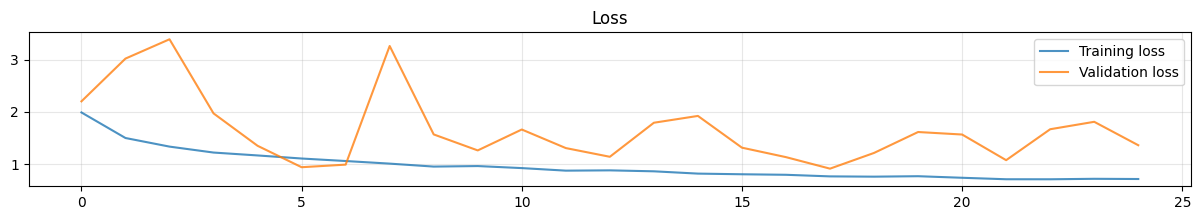

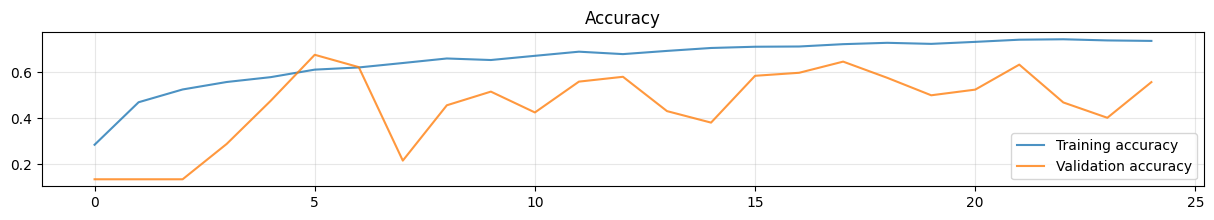

In [44]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)